In [1]:
from massspecgym.utils import show_mols
%load_ext autoreload
%autoreload 2

In [2]:
import json

import matplotlib.pyplot as plt
import pandas as pd

from pandarallel import pandarallel

import massspecgym.utils as utils

import random
from pathlib import Path
from rdkit import Chem, RDLogger
from massspecgym.utils import show_mols
from IPython.display import display

In [3]:
# Suppress RDKit warnings and errors
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

pandarallel.initialize(nb_workers=6, progress_bar=True)

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [7]:
with open('/Users/macbook/CODE/Majer:MassSpecGym/data/candidates_generation/MassSpecGymMSn_retrieval_candidates_mass.json') as f:
# with open('./MassSpecGym_retrieval_candidates_mass.json') as f:
    cands_mass = json.load(f)
cands_mass = pd.DataFrame({'smiles': cands_mass.keys(), 'cands': cands_mass.values()})

with open('/Users/macbook/CODE/Majer:MassSpecGym/data/candidates_generation/MassSpecGymMSn_retrieval_candidates_formula.json') as f:
# with open('./MassSpecGym_retrieval_candidates_formula.json') as f:
    cands_formula = json.load(f)
cands_formula = pd.DataFrame({'smiles': cands_formula.keys(), 'cands': cands_formula.values()})

## Number of candidates

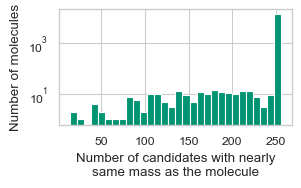

n_cands
256    13797
106        4
188        4
243        4
203        4
       ...  
221        1
164        1
50         1
125        1
143        1
Name: count, Length: 128, dtype: int64

In [8]:
cands_mass['n_cands'] = cands_mass['cands'].apply(len)
utils.init_plotting(figsize=(3, 1.5))
cands_mass['n_cands'].hist(bins=30)
plt.yscale('log')
plt.xlabel('Number of candidates with nearly\nsame mass as the molecule')
plt.ylabel('Number of molecules')
# plt.savefig('n_cands_mass.svg', bbox_inches='tight')
plt.show()
cands_mass['n_cands'].value_counts()

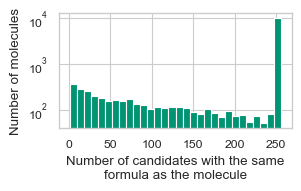

n_cands
256    10063
5         51
4         48
2         46
7         45
       ...  
233        3
214        3
255        3
144        2
232        2
Name: count, Length: 256, dtype: int64

In [9]:
cands_formula['n_cands'] = cands_formula['cands'].apply(len)
utils.init_plotting(figsize=(3, 1.5))
cands_formula['n_cands'].hist(bins=30)
plt.yscale('log')
plt.xlabel('Number of candidates with the same\nformula as the molecule')
plt.ylabel('Number of molecules')
# plt.savefig('n_cands_formula.svg', bbox_inches='tight')
plt.show()
cands_formula['n_cands'].value_counts()

## Number of positive samples among candidates

In [10]:
def n_pos(row):
    inchi_true = utils.smiles_to_inchi_key(row['smiles'])
    return sum(utils.smiles_to_inchi_key(c) == inchi_true for c in row['cands'])

cands_mass['n_pos'] = cands_mass.parallel_apply(n_pos, axis=1)
cands_mass['n_pos'].value_counts()

n_pos
1    14008
Name: count, dtype: int64

In [13]:
cands_mass['n_pos'].value_counts()

n_pos
1    14008
Name: count, dtype: int64

In [11]:
def n_pos(row):
    inchi_true = utils.smiles_to_inchi_key(row['smiles'])
    return sum(utils.smiles_to_inchi_key(c) == inchi_true for c in row['cands'])

cands_formula['n_pos'] = cands_formula.parallel_apply(n_pos, axis=1)
cands_formula['n_pos'].value_counts()

n_pos
1    14008
Name: count, dtype: int64

In [ ]:
cands_formula['n_pos'].value_counts()

## Analyze InChiKeys of queries

In [12]:
len(cands_mass['smiles']), cands_mass['smiles'].apply(utils.smiles_to_inchi_key).nunique()

(14008, 13709)

## Show candidates molecules 


In [ ]:
mass_candidates_path = "/Users/macbook/CODE/Majer:MassSpecGym/data/candidates_generation/MassSpecGymMSn_retrieval_candidates_mass.json"
formula_candidates_path = "/Users/macbook/CODE/Majer:MassSpecGym/data/candidates_generation/MassSpecGymMSn_retrieval_candidates_formula.json"

In [13]:
# suppress RDKit warnings
RDLogger.DisableLog('rdApp.*')

# Paths to your two JSON files
mass_pth    = Path("/Users/macbook/CODE/Majer:MassSpecGym/data/candidates_generation/MassSpecGymMSn_retrieval_candidates_mass.json")
formula_pth = Path("/Users/macbook/CODE/Majer:MassSpecGym/data/candidates_generation/MassSpecGymMSn_retrieval_candidates_formula.json")

# Load them
with mass_pth.open() as f:
    mass_cands = json.load(f)
with formula_pth.open() as f:
    formula_cands = json.load(f)

# Find keys common to both
common_keys = set(mass_cands) & set(formula_cands)
if not common_keys:
    raise ValueError("No overlapping keys between the two files.")

# Pick one at random
selected = random.choice(list(common_keys))
print(f"Selected query molecule: {selected}")

# Sample up to ten candidates from each list
mass_list    = mass_cands[selected]
formula_list = formula_cands[selected]

n = 10
mass_sample    = random.sample(mass_list,    min(n, len(mass_list)))
formula_sample = random.sample(formula_list, min(n, len(formula_list)))

# Render each as a 2×5 grid (mols_per_row=5)
grid_mass = show_mols(
    mass_sample,
    smiles_in=True,
    legends='masses',
    mols_per_row=5,
    max_mols=10,
    # legend_float_decimals=2
)
grid_formula = show_mols(
    formula_sample,
    smiles_in=True,
    legends='masses',
    mols_per_row=5,
    max_mols=10,
    # legend_float_decimals=2
)

# Display inline (in Jupyter / notebook)
# display(grid_mass)
# display(grid_formula)

Selected query molecule: CC[C@@H]1C(=O)N(C(=O)N1)C2=CN=C(C=C2)OC3=CC(=C(C=C3)C)OC


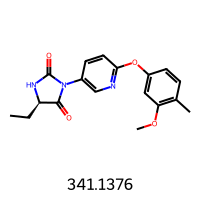

In [14]:
mol = Chem.MolFromSmiles(selected)

# Option A: use your show_mols helper
single_grid = show_mols([selected], smiles_in=True,
                        legends='masses',  
                        mols_per_row=1, max_mols=1,
                        svg=False)
display(single_grid)

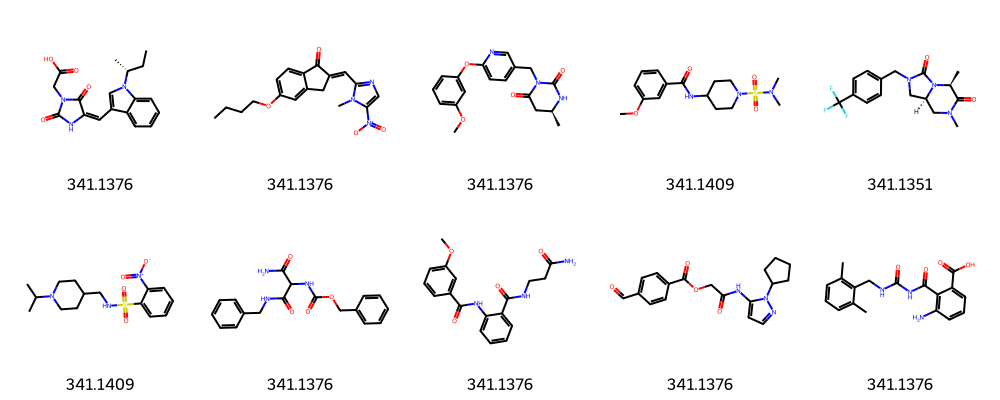

In [15]:
display(grid_mass)

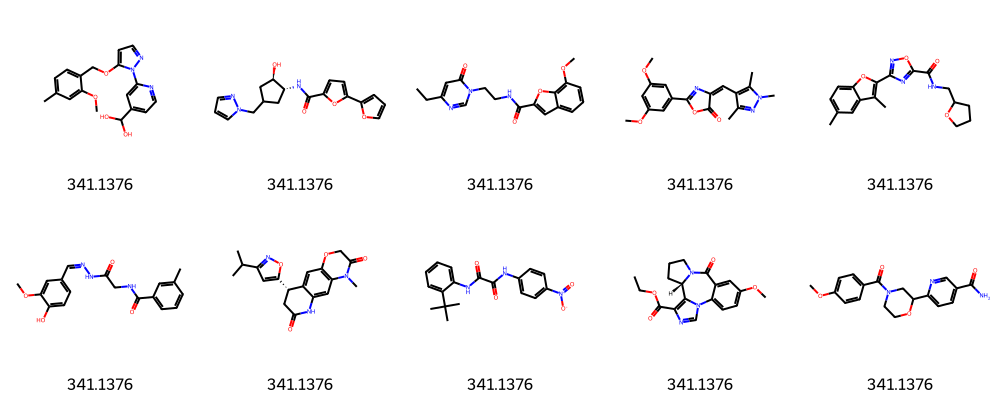

In [16]:
display(grid_formula)